<a href="https://colab.research.google.com/github/Pacharaponarp/Tuberculosis-Covid-19-Classification/blob/main/Tuberculosis(Montgomery).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import os, warnings
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from skimage import data, img_as_float
from skimage import exposure

def set_seed(seed=12345):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir '/content/data'
!cp -av '/content/gdrive/MyDrive/indiv1/MontgomerySet/ClinicalReadings' '/content/data/ClinicalReadings'
!cp -av '/content/gdrive/MyDrive/indiv1/MontgomerySet/CXR_png' '/content/data/CXR_png'

'/content/gdrive/MyDrive/indiv1/MontgomerySet/ClinicalReadings' -> '/content/data/ClinicalReadings'
'/content/gdrive/MyDrive/indiv1/MontgomerySet/ClinicalReadings/MCUCXR_0023_0.txt' -> '/content/data/ClinicalReadings/MCUCXR_0023_0.txt'
'/content/gdrive/MyDrive/indiv1/MontgomerySet/ClinicalReadings/MCUCXR_0069_0.txt' -> '/content/data/ClinicalReadings/MCUCXR_0069_0.txt'
'/content/gdrive/MyDrive/indiv1/MontgomerySet/ClinicalReadings/MCUCXR_0026_0.txt' -> '/content/data/ClinicalReadings/MCUCXR_0026_0.txt'
'/content/gdrive/MyDrive/indiv1/MontgomerySet/ClinicalReadings/MCUCXR_0126_1.txt' -> '/content/data/ClinicalReadings/MCUCXR_0126_1.txt'
'/content/gdrive/MyDrive/indiv1/MontgomerySet/ClinicalReadings/MCUCXR_0060_0.txt' -> '/content/data/ClinicalReadings/MCUCXR_0060_0.txt'
'/content/gdrive/MyDrive/indiv1/MontgomerySet/ClinicalReadings/MCUCXR_0082_0.txt' -> '/content/data/ClinicalReadings/MCUCXR_0082_0.txt'
'/content/gdrive/MyDrive/indiv1/MontgomerySet/ClinicalReadings/MCUCXR_0253_1.txt' ->

In [ ]:
drive.flush_and_unmount()
txt_path = '/content/data/ClinicalReadings'
img_path = '/content/data/CXR_png'

In [ ]:
#put file name & label into a dataframe
label_list = []
for filename in os.listdir(txt_path) :
  f = open(os.path.join(txt_path,filename),'r')
  lines = f.readlines()
  label = lines[2]
  if label.strip() == 'normal':
    label_list.append('normal')
  else:
    label_list.append('tb')
  f.close()
df = pd.DataFrame(list(zip(os.listdir(img_path),label_list)) , columns =['filename', 'label'])

#train test split
df_train,df_val = train_test_split(df,test_size = 0.15, random_state = 1,stratify = df.label )
print("train normal:", df_train.loc[df_train.label == "normal"].shape[0])
print("train tb:", df_train.loc[df_train.label == "tb"].shape[0])
print("val normal:", df_val.loc[df_val.label == "normal"].shape[0])
print("val tb:", df_val.loc[df_val.label == "tb"].shape[0])


train normal: 68
train tb: 49
val normal: 12
val tb: 9


Found 117 validated image filenames belonging to 2 classes.
Found 20 validated image filenames belonging to 2 classes.
(150, 150, 3)
(150, 150, 3)


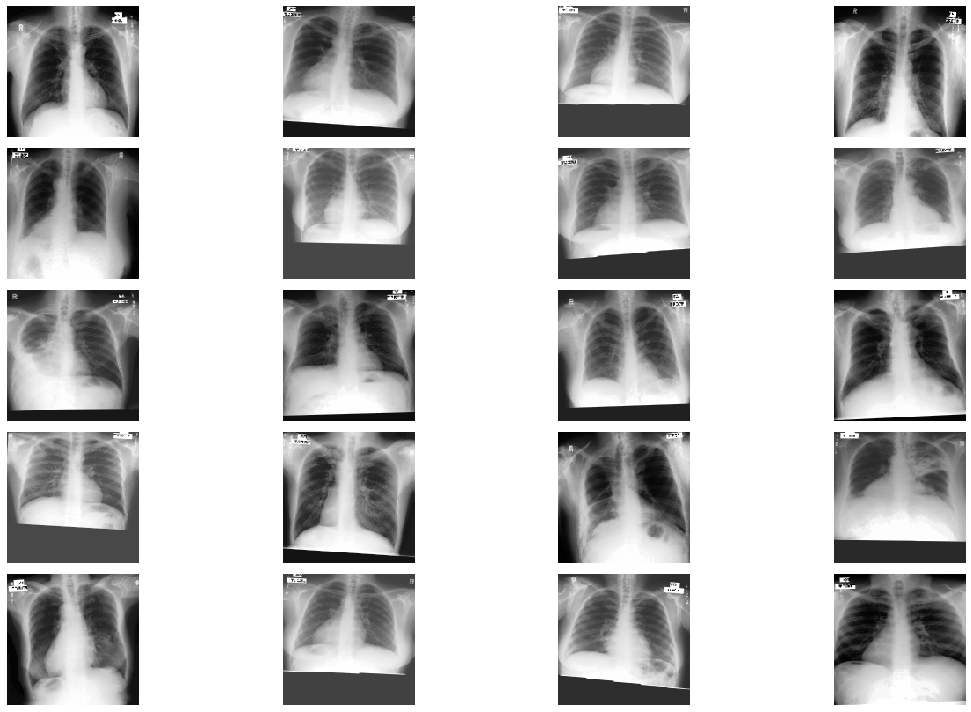

In [ ]:
def hist_equal(img):
  return exposure.equalize_hist(img)*255

#imagedatagenerator
datagen = ImageDataGenerator(
    horizontal_flip = True,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range= [0.9,1.0],
    preprocessing_function = hist_equal
)
val_datagen = ImageDataGenerator(
    preprocessing_function = hist_equal
)
train_gen = datagen.flow_from_dataframe(
    df_train,directory = img_path,
    x_col='filename', 
    y_col='label',
    target_size=(150, 150),
    batch_size = 32,
    class_mode = 'categorical'
)
val_gen = val_datagen.flow_from_dataframe(
    df_val,directory = img_path,
    x_col='filename', 
    y_col='label',
    target_size=(150, 150),
    batch_size = 32,
    class_mode = 'categorical'
)
ims,labels = train_gen.next()
interp = False
# plot raw pixel data
print(ims[0].shape)
print(hist_equal(ims[0]).shape)
#print(ims[0])
if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
f = plt.figure(figsize=(20,10))
for i in range(20):
        sp = f.add_subplot(5, 4, i+1)
        sp.axis('Off')
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [ ]:
pretrained_model = tf.keras.applications.ResNet101(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet',
)
pretrained_model.trainable = False

model =keras.Sequential([
    layers.InputLayer(input_shape=(150, 150,3)),
    pretrained_model,
    layers.Flatten(),
    #layers.BatchNormalization(renorm=True),
    #layers.Dense(units = 32, activation = 'relu'),
    #layers.Dropout(rate=0.1),
    layers.Dense(units = 2,activation = 'softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0003)
model.compile(
    optimizer=optimizer,
    loss = 'binary_crossentropy',
    metrics=['accuracy'],
)

model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 5, 5, 2048)        42658176  
_________________________________________________________________
flatten_3 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102402    
Total params: 42,760,578
Trainable params: 102,402
Non-trainable params: 42,658,176
_________________________________________________________________


In [ ]:
#early stopping,checkpoint,reduce_lr and scheduler

early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0,
    restore_best_weights=True,
)
filepath = '/content/data/'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
lrScheduler = keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
history = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[checkpoint,reduce_lr]
)

Epoch 1/30
4/4 [==============================] - 53s 12s/step - loss: 2.1169 - accuracy: 0.4530 - val_loss: 1.5580 - val_accuracy: 0.6000

Epoch 00001: val_accuracy improved from -inf to 0.60000, saving model to /content/data/
INFO:tensorflow:Assets written to: /content/data/assets
Epoch 2/30
4/4 [==============================] - 37s 10s/step - loss: 1.4273 - accuracy: 0.5556 - val_loss: 1.4173 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 0.60000
Epoch 3/30
4/4 [==============================] - 37s 9s/step - loss: 1.0021 - accuracy: 0.6838 - val_loss: 0.8608 - val_accuracy: 0.5500

Epoch 00003: val_accuracy did not improve from 0.60000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
Epoch 4/30
4/4 [==============================] - 36s 9s/step - loss: 0.9212 - accuracy: 0.6752 - val_loss: 0.9263 - val_accuracy: 0.6000

Epoch 00004: val_accuracy did not improve from 0.60000
Epoch 5/30
4/4 [==============================] - 36

best


accuracy        0.837607
val_accuracy    0.700000
dtype: float64

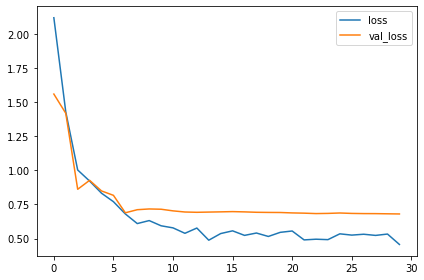

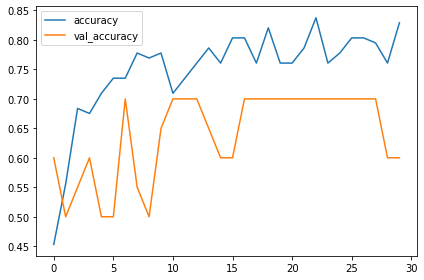

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
print('best')
history_frame.loc[:, ['accuracy', 'val_accuracy']].max()

In [ ]:
results_val = model.evaluate_generator(val_gen, verbose=0)
print("    Val Loss: {:.5f}".format(results_val[0]))
print("Val Accuracy: {:.2f}%".format(results_val[1] * 100))

    Val Loss: 0.68009
Val Accuracy: 60.00%


In [ ]:
import sys
sys.path.append('drive/Project')
model.save('drive/Project/myModel.h5')
